In [1]:
# Library imports.
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
from pathlib import Path
import scipy
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import ExtraTreesClassifier
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Urbansurge imports.
from urbansurge import swmm_model, analysis_tools, file_utils
from urbansurge.fault_diagnosis import ann_classifier, ann_regressor, dtw_knn_classifier, quant, cnn_classifier, data_utils
from urbansurge.fault_diagnosis.accuracy_metrics import true_positive_rate

# Autoreload.
%load_ext autoreload
%autoreload 2

In [2]:
# SWMM model configuration file path.
config_path = r"C:\Users\ay434\Documents\urbansurge\analysis\lab_system\lab_system_config.yml"

# Node where impulse is added.
input_node = 18

# Physical model fault database path.
phy_save_fp = r"C:\Users\ay434\Documents\urbansurge\analysis\lab_system\diagnosis_pipeline\phy_impulse_fault_database.csv"

# Simulation model fault database path.
sim_save_fp = r"C:\Users\ay434\Documents\urbansurge\analysis\lab_system\diagnosis_pipeline\sim_impulse_fault_database.csv"

# Physical model with no faults (i.e., "healthy" case)
phy_healthy_save_fp = r"C:\Users\ay434\Documents\urbansurge\analysis\lab_system\diagnosis_pipeline\phy_healthy_impulse_database.csv"

# Simulation model with no faults (i.e., "healthy" case)
sim_healthy_save_fp = r"C:\Users\ay434\Documents\urbansurge\analysis\lab_system\diagnosis_pipeline\sim_healthy_impulse_database.csv"

# Figure save path.
fig_savefp = Path(r'C:\Users\ay434\Box\Research\Smart_Stormwater\Fault_Diagnosis_Paper\Manuscript\manuscript-v1\Figures')

In [3]:
# Create instance of SWMM model.
swmm = swmm_model.SWMM(config_path)

# Configure model.
swmm.configure_model()

Simulation info
Flow Units: CFS
System Units: US
Start Time: 2020-01-01 00:00:00
Start Time: 2020-01-01 06:00:00


In [6]:
# Physical system fault database.
phy_db = pd.read_csv(phy_save_fp)

# Simulation system fault database.
sim_db = pd.read_csv(sim_save_fp)

# Physical healthy system run.
phy_healthy_db = pd.read_csv(phy_healthy_save_fp)

# Simulated healthy system run.
sim_healthy_db = pd.read_csv(sim_healthy_save_fp)

In [7]:
# Depth and velocity columns.
dep_vel_cols = [s for s in sim_healthy_db if any(sub in s for sub in ['Depth_link', 'Velocity'])]

# Select sensors.
links = [20, 21, 23, 45, 44, 43, 42, 41, 40, 39]
skips = [1, 2, 3, 4, 5, 10]

In [45]:
# Fault types.
fault_types = np.unique(sim_db.fault_type)

# Severity density arrays for storing diagnosis accuracy metrics.
severity_density_arrays = {}
severity_dict = {}
for fault_type in fault_types:
    # Severity levels.
    severity_levels = np.unique(sim_db.loc[sim_db.fault_type==fault_type, 'fault_value'])
    severity_dict[fault_type] = severity_levels

    severity_density_ar = np.zeros((len(severity_levels), len(skips)))
    severity_density_arrays[fault_type] = severity_density_ar
    print(severity_density_ar.shape)
    
# Scenarios.
scenarios = np.unique(sim_db.scenario)
scenario_fault_types = [sim_db.loc[sim_db.scenario==scenario, 'fault_type'].iloc[0] for scenario in scenarios]
scenario_fault_types = np.array(scenario_fault_types)
scenario_severities = [sim_db.loc[sim_db.scenario==scenario, 'fault_value'].iloc[0] for scenario in scenarios]
scenario_severities = np.array(scenario_severities)

(15, 6)
(15, 6)
(21, 6)


In [203]:
print(severity_dict['diameter'])

[0.1        0.15714286 0.21428571 0.27142857 0.32857143 0.38571429
 0.44285714 0.5        0.55714286 0.61428571 0.67142857 0.72857143
 0.78571429 0.84285714 0.9       ]


In [157]:
# Number of hours to retain.
clip_hours = 2

# Noise standard deviation.
noise_std = 0.08

[autoreload of urbansurge.fault_diagnosis.data_utils failed: Traceback (most recent call last):
  File "c:\users\ay434\desktop\python\urbansurge-env\lib\site-packages\IPython\extensions\autoreload.py", line 273, in check
    superreload(m, reload, self.old_objects)
  File "c:\users\ay434\desktop\python\urbansurge-env\lib\site-packages\IPython\extensions\autoreload.py", line 471, in superreload
    module = reload(module)
  File "C:\Users\ay434\AppData\Local\Programs\Python\Python39\lib\importlib\__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 613, in _exec
  File "<frozen importlib._bootstrap_external>", line 851, in exec_module
  File "<frozen importlib._bootstrap_external>", line 988, in get_code
  File "<frozen importlib._bootstrap_external>", line 918, in source_to_code
  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
  File "C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagn

In [158]:
severity_density_ar = np.zeros(())
for skip_idx, skip in enumerate(skips):
    print(skip_idx)
    # Sensor columns.
    sensor_links = links[::skip]
    print(sensor_links)
    dep_cols = [f'Depth_link_{s}' for s in sensor_links]
    vel_cols = [f'Velocity_link_{s}' for s in sensor_links]
    vel_cols = []
    dep_vel_cols = dep_cols + vel_cols

    # Clipped data frames.
    phy_db_clip = data_utils.clip_timeseries(phy_db, clip_hours)
    sim_db_clip = data_utils.clip_timeseries(sim_db, clip_hours)
    phy_healthy_db_clip = data_utils.clip_timeseries(phy_healthy_db, clip_hours, by_scenario=False) 
    sim_healthy_db_clip = data_utils.clip_timeseries(sim_healthy_db, clip_hours, by_scenario=False) 
    
    # Add noise to physical data.
    phy_db_clip[dep_vel_cols] += np.random.normal(0, noise_std, size=phy_db_clip[dep_vel_cols].shape)
    
#     # Residual data frames.
#     phy_residual_df = data_utils.compute_residuals(phy_db_clip, phy_healthy_db_clip, dep_vel_cols)
#     sim_residual_df = data_utils.compute_residuals(sim_db_clip, sim_healthy_db_clip, dep_vel_cols)
    
    # Normalize residuals.
#     phy_residual_norm_df = data_utils.normalize_states(swmm, phy_residual_df, sensor_links, norm_type=None)
#     sim_residual_norm_df = data_utils.normalize_states(swmm, sim_residual_df, sensor_links, norm_type=None)
    phy_norm_df = data_utils.normalize_states(swmm, phy_db_clip, sensor_links, norm_type=None)
    sim_norm_df = data_utils.normalize_states(swmm, sim_db_clip, sensor_links, norm_type=None)
    
    # Reshape state variable arrays into 3D arrays where each slice is a separate scenario.
#     Xphy_res, yphy_res = data_utils.prepare_states(phy_residual_norm_df, dep_vel_cols)
#     Xsim_res, ysim_res = data_utils.prepare_states(sim_residual_norm_df, dep_vel_cols)
    Xphy, yphy = data_utils.prepare_states(phy_norm_df, dep_vel_cols)
    Xsim, ysim = data_utils.prepare_states(sim_norm_df, dep_vel_cols)
    
    #### Fault Detection ####
    # ============================================================================================
    # Generate baseline observations.
    n_samples = 5
    d_obs_baseline = np.zeros((phy_healthy_db_clip.shape[0], len(dep_vel_cols), n_samples))
    for i in range(n_samples):
        d_obs_noiseless = phy_healthy_db_clip[dep_vel_cols].to_numpy()
        d_obs = d_obs_noiseless + np.random.normal(0, noise_std, size=d_obs_noiseless.shape)
        d_obs_baseline[:,:,i] = d_obs

    # Ensemble of baseline observations.
    phy_baseline_ens = np.mean(d_obs_baseline, axis=2)

    # Subtract the ensemble mean from the individual observations of baseline states.
    mean_subtract = d_obs_baseline - phy_baseline_ens[:, :, np.newaxis]
    print(mean_subtract.shape)

    # Exceeding thresholds for each sensor.
    exceed_thresh = [np.mean(np.percentile(np.abs(mean_subtract[:,i,:]), 99, axis=0)) for i in range(mean_subtract.shape[1])]
    print('95% exceedance thresholds:', exceed_thresh)

    # 95% exceedance counts.
    exceed_95 = [np.sum(np.abs(mean_subtract[:,i,:]) > exceed_thresh[i]) / mean_subtract.shape[2]
                 for i in range(mean_subtract.shape[1])]
    print('95% exceedance counts:', exceed_95)
    
    # Compute 95% inverse poisson to get number of exceedances to trigger fault.
    N_thresh = [scipy.stats.poisson.ppf(.99, exceed_95[i]) for i in range(mean_subtract.shape[1])]
    print('Number of points corresponding to 99% threshold', N_thresh)
           
    # Exceedance counts for fault scenarios.
    exceeders = np.zeros((len(scenarios), len(sensor_links)))
    for i, scenario in enumerate(scenarios):
        # Observed time series array for all sensors.
        dobs = Xphy[:,:,i]

        for sensor in sensor_links:
            sensor_idx = sensor_links.index(sensor)

            # Observed differences.
            abs_obs_diffs = np.abs(dobs[:,sensor_idx] - phy_baseline_ens[:,sensor_idx])

            # Count of exceeding values.
            exceeders[i, sensor_idx] = np.sum(abs_obs_diffs > exceed_thresh[sensor_idx])
    
    # Fault detection accuracy.
    faults_detected = np.any(exceeders > N_thresh, axis=1)
#     detection_rate = np.sum(faults_detected) / len(faults_detected)
    
    # Populate severity density arrays.
    for fault_type in fault_types:
        # Severity levels.
        severity_levels = severity_dict[fault_type]
        
        for j, severity_level in enumerate(severity_levels):
            detection = faults_detected[(scenario_fault_types==fault_type) & (scenario_severities==severity_level)]
            severity_density_arrays[fault_type][j, skip_idx] = np.sum(detection) / len(detection)
    # ============================================================================================

0
[20, 21, 23, 45, 44, 43, 42, 41, 40, 39]
(121, 10, 5)
95% exceedance thresholds: [0.1724203384151799, 0.17401537127105904, 0.17191899408589653, 0.16626438853478293, 0.18213464622656123, 0.16870057979160832, 0.16742126654125752, 0.17670611275794898, 0.16661949486666455, 0.17743412448645218]
95% exceedance counts: [1.4, 2.4, 2.0, 1.8, 1.8, 1.8, 1.8, 1.8, 2.4, 1.6]
Number of points corresponding to 99% threshold [5.0, 7.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 7.0, 5.0]
1
[20, 23, 44, 42, 40]
(121, 5, 5)
95% exceedance thresholds: [0.1810497060329554, 0.17353866464467677, 0.17905607108984728, 0.18275236038551265, 0.18035001525778122]
95% exceedance counts: [1.6, 1.8, 2.2, 1.6, 1.6]
Number of points corresponding to 99% threshold [5.0, 6.0, 6.0, 5.0, 5.0]
2
[20, 45, 42, 39]
(121, 4, 5)
95% exceedance thresholds: [0.16950466844362713, 0.17914204581887286, 0.18457867671789283, 0.16964612565616086]
95% exceedance counts: [1.6, 1.8, 1.4, 1.6]
Number of points corresponding to 99% threshold [5.0, 6.0

Total Length = 2275.0 ft
Total Length = 2275.0 ft
Total Length = 2275.0 ft


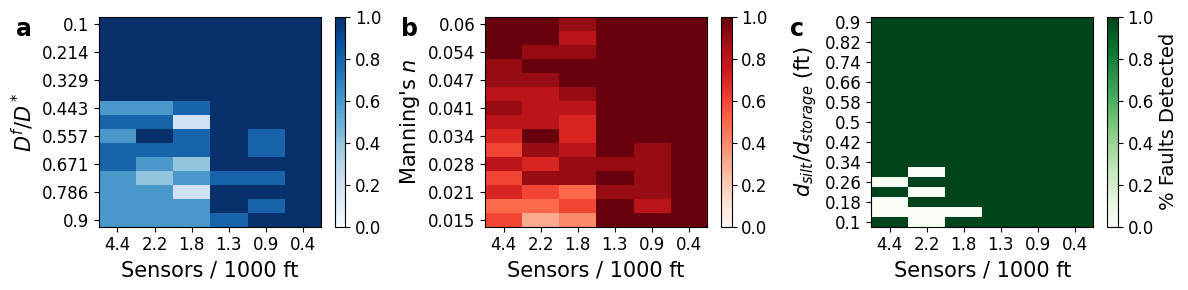

In [206]:
fig, axes = plt.subplots(1, 3, figsize=(12,3))
for i, fault_type in enumerate(fault_types):
    # Fault type to plot.
#     fault_type = 'roughness'

    # Colormap names.
    if fault_type == 'diameter':
        cmap_name = 'Blues'
        ylabel = '$D^f / D^*$'
        severities = severity_dict[fault_type][::-1]
        yticks = [0.1, 0.3, 0.5, 0.7, 0.9]
    elif fault_type == 'roughness':
        cmap_name = 'Reds'
        ylabel = "Manning's $n$"
        severities = severity_dict[fault_type] * 0.01 
        yticks = np.linspace(0.015, 0.06, 4)
    elif fault_type == 'silting':
        cmap_name = 'Greens'
        ylabel = '$d_{silt} / d_{storage}$ (ft)'
        severities = severity_dict[fault_type]
        yticks = [0.1, 0.3, 0.5, 0.7, 0.9]

    # Plotting array.
    plotting_ar = severity_density_arrays[fault_type]
    nrow, ncol = plotting_ar.shape

    # Total length of flow path.
    total_length = swmm.upstream_distance(20, 'Link', 18, 'Junction')
    print(f'Total Length = {total_length} ft')

    # Number of sensors at each density.
    n_sensors = [10, 5, 4, 3, 2, 1]

    # Sensors / distance.
    dist = 1000
    sensors_per_dist = n_sensors / total_length * dist

#     fig, ax = plt.subplots()
    ax = axes[i]
    cf = ax.imshow(np.fliplr(plotting_ar), cmap=cmap_name, origin='lower', aspect='auto', vmin=0, vmax=1)
    cbar = fig.colorbar(cf, ax=ax)
    if i == 2:
        cbar.set_label('% Faults Detected', fontsize=14)
    cbar.ax.tick_params(labelsize=12)
    cbar.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_xlabel(f'Sensors / {dist} ft', fontsize=15)
    ax.set_ylabel(ylabel, fontsize=15)
    ax.tick_params(axis='both', labelsize=12)
    # X-ticks.
    xtick_idx = np.arange(0, ncol, 1)
    ax.set_xticks(xtick_idx)
    ax.set_xticklabels(np.round(sensors_per_dist, 1))
    # Y-ticks.
    ytick_idx = np.arange(0, nrow, 2)
    ax.set_yticks(ytick_idx)
    ax.set_yticklabels(np.round(severities[ytick_idx], 3))
    
    # Add subfigure letter.
    halign=1
    subplot_labels = ['a', 'b', 'c']
    ax.text(-0.3, halign, subplot_labels[i],
        transform=ax.transAxes,  # Coordinates relative to the axis (0,0) to (1,1)
        fontsize=17,             # Font size
        verticalalignment='top', # Align text to the top
        horizontalalignment='right',  # Align text to the right
        weight='bold')
    
fig.tight_layout()
fig.savefig(fig_savefp / 'detection_accuracy.png', dpi=300)